In [192]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import shap

In [193]:
warnings.filterwarnings('ignore')

In [194]:
train_df_final = pd.read_csv('./input/processed/train_df_final_v5.csv')
test_df_final = pd.read_csv('./input/processed/test_df_final_v5.csv')

In [195]:
train_df_final.head()

,id,climatology_temp,target,elev,doy_sin,doy_cos,day_length,dew_point_avg,humidity_avg,dew_humidity_interaction,...,dew_change_day_X_humidity_avg,clim_doy_cos_X_slp_avg_base,clim_doy_cos_slp_X_doy_sin_sq,dp_evening_avg_X_pressure_tendency,DCD_Hum_X_log_elev,LMC_X_ratio_STA_elev_div_hum,ratio_TEMNA_div_wind,R_LMC_STA_WIND_X_elev_sq,precip_contrib_max_hr_X_elev_sq,Top1_X_day_length
0,0,-2.707143,-3.992857,115.62,0.017213,0.999852,9.426812,-16.808333,46.875000,-787.890625,...,268.750000,-2799.887516,-0.829606,32.648333,1276.645533,-31.003020,1.760390,-98597.507314,1548.416765,-9.294601e+05
1,1,-3.646429,-1.653571,115.62,0.034422,0.999407,9.437325,-17.466667,45.500000,-794.733333,...,525.525000,-3772.333341,-4.469639,-18.736667,2496.406116,-33.168857,3.082248,-181289.935304,1672.464844,-1.710892e+06
2,2,-2.694643,-0.005357,115.62,0.051620,0.998667,9.448699,-17.645833,43.583333,-769.064236,...,584.743056,-2788.051558,-7.429014,-7.420000,2777.710176,-43.021782,4.217817,-257573.492734,1672.555693,-2.433734e+06
3,3,-2.501786,-0.898214,115.62,0.068802,0.997630,9.460926,-11.966667,53.166667,-636.227778,...,257.858333,-2575.183909,-12.190338,48.720000,1224.906751,-13.217564,4.617882,-79268.297718,1517.375165,-7.499515e+05
4,4,-2.625000,-1.775000,115.62,0.085965,0.996298,9.473997,-15.729167,40.583333,-638.342014,...,594.545833,-2688.314479,-19.866501,-32.106667,2824.276399,-12.493280,-0.221574,-41017.953652,1734.218506,-3.886040e+05


# Dataset Splitting

In [196]:
features = [col for col in train_df_final.columns if col not in ['id', 'target']]

X = train_df_final[features].values
y = train_df_final['target'].values
X_test = test_df_final[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Optuna Setup

In [197]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 1000, 8000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'random_state': 52,
        'verbosity': 0
    }
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False,
    )
    preds = model.predict(X_val)
    return root_mean_squared_error(y_val, preds)

In [198]:
# study = optuna.create_study(direction='minimize', study_name='xgb_reg_opt')
# study.optimize(objective, n_trials=50, n_jobs=-1)
# print("Best trial:")
# print(f"  RMSE: {study.best_value:.5f}")
# print(f"  Params: {study.best_params}")
#
# best_params = study.best_params.copy()
# best_params.update({
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'random_state': 52,
#     'verbosity': 0
# })

In [199]:
best_params = {'n_estimators': 6000, 'learning_rate': 0.04301669654154669, 'max_depth': 5, 'subsample': 0.686853543077099, 'colsample_bytree': 0.6974010880163497, 'min_child_weight': 0.15793160713168192, 'gamma': 7.333260919965793e-08, 'reg_alpha': 0.005971371924073574, 'reg_lambda': 0.025035399359745195}

# Fit

In [200]:
xgb_model = xgb.XGBRegressor(**best_params)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_pred = xgb_model.predict(X_val)
r2 = r2_score(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"\n✅ XGB R²: {r2:.4f} | RMSE: {rmse:.4f}")


✅ XGB R²: 0.8164 | RMSE: 1.2828


# Feature Importance

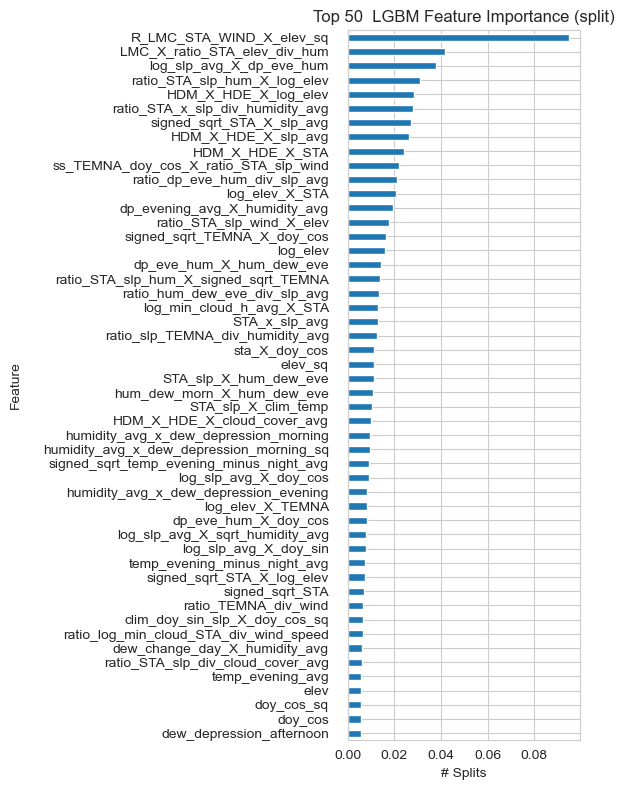

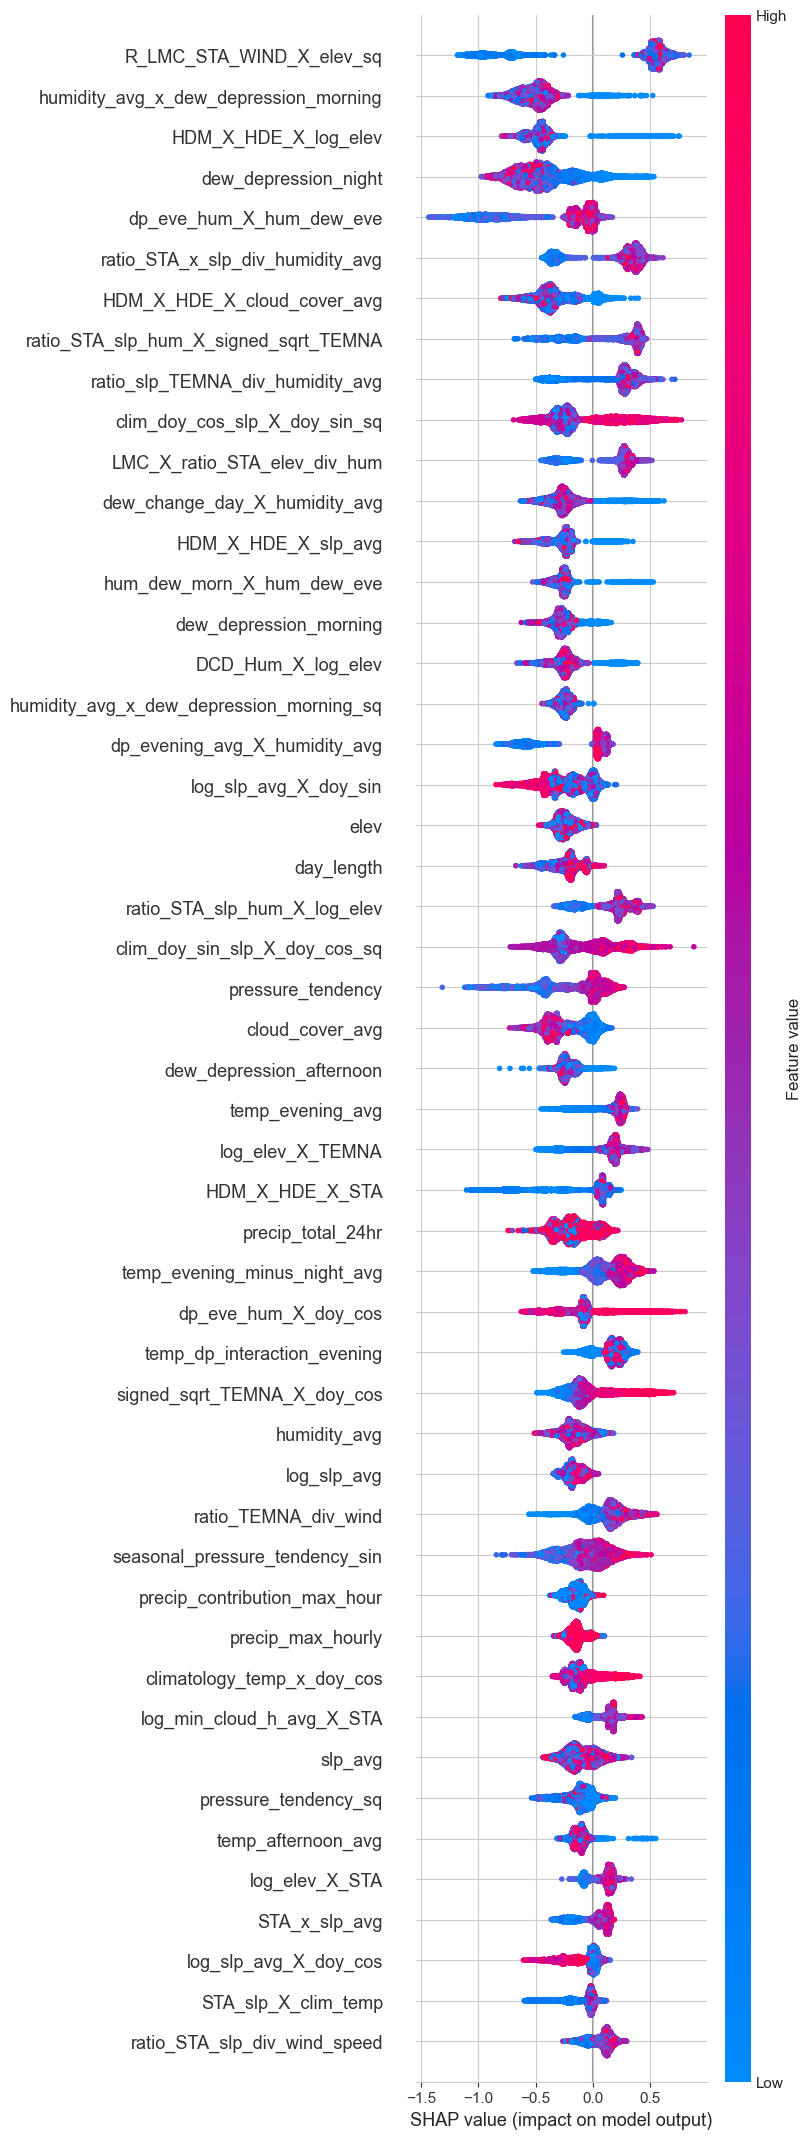

In [201]:
imp_split = xgb_model.feature_importances_

feat_imp_split = pd.Series(imp_split, index=features).sort_values(ascending=False)

top_N = 50

# 1) Plot split importances
fig, ax = plt.subplots(figsize=(6, 8))
feat_imp_split.head(top_N).plot(kind='barh', ax=ax)
ax.invert_yaxis()
ax.set_title(f'Top {top_N}  LGBM Feature Importance (split)')
ax.set_xlabel('# Splits')
ax.set_ylabel('Feature', labelpad=15)
ax.tick_params(axis='y', pad=10)
plt.subplots_adjust(left=0.3)
plt.tight_layout()
plt.show()

# 2) SHAP Summary Plots
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, max_display=top_N, feature_names=features)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feat_shap_imp = pd.Series(mean_abs_shap, index=features).sort_values(ascending=False)

In [202]:
print(f"Top {top_N} XGB Importances (split):")
print(feat_imp_split.head(top_N).to_string())
print("="*50)
print("Top SHAP Feature Importances (mean |SHAP value|):")
print(feat_shap_imp.head(top_N).to_string())

Top 50 XGB Importances (split):
R_LMC_STA_WIND_X_elev_sq                    0.094786
LMC_X_ratio_STA_elev_div_hum                0.041888
log_slp_avg_X_dp_eve_hum                    0.037806
ratio_STA_slp_hum_X_log_elev                0.031056
HDM_X_HDE_X_log_elev                        0.028533
ratio_STA_x_slp_div_humidity_avg            0.027963
signed_sqrt_STA_X_slp_avg                   0.027194
HDM_X_HDE_X_slp_avg                         0.026100
HDM_X_HDE_X_STA                             0.024109
ss_TEMNA_doy_cos_X_ratio_STA_slp_wind       0.021994
ratio_dp_eve_hum_div_slp_avg                0.021115
log_elev_X_STA                              0.020482
dp_evening_avg_X_humidity_avg               0.019509
ratio_STA_slp_wind_X_elev                   0.017524
signed_sqrt_TEMNA_X_doy_cos                 0.016370
log_elev                                    0.016116
dp_eve_hum_X_hum_dew_eve                    0.014206
ratio_STA_slp_hum_X_signed_sqrt_TEMNA       0.014008
ratio_hum_dew_

# Feature Selection with SHAP

In [203]:
print("Lowest SHAP Importances:")
print(feat_shap_imp.tail(50).to_string())

Lowest SHAP Importances:
climatology_temp_x_doy_sin                     0.092574
humidity_avg_x_dew_depression_evening          0.092199
pressure_tendency_sq_X_clim_doy_cos            0.090837
ss_TEMNA_doy_cos_X_ratio_STA_slp_wind          0.089671
seasonal_pressure_tendency_cos                 0.089623
temp_night_avg                                 0.088380
temp_dp_interaction_night                      0.088039
log_slp_avg_X_sqrt_humidity_avg                0.087792
precip_std_dev_24hr                            0.087771
dp_morning_avg                                 0.085747
dew_depression_change_day_progress             0.085018
signed_sqrt_STA_X_slp_avg                      0.083947
dew_point_avg                                  0.083377
dp_evening_avg_X_pressure_tendency             0.082011
dp_afternoon_avg                               0.079200
sqrt_humidity_avg                              0.076015
surface_temp_anomaly                           0.071243
clim_doy_cos_X_slp_avg_

# Predict with Test Dataset

In [204]:
y_test_pred = xgb_model.predict(X_test_scaled)

submission = pd.DataFrame({
    "id": test_df_final["id"],
    "target": y_test_pred
})

now = datetime.now().strftime("%Y%m%d_%H%M%S")

submission.to_csv(f'./output/submission_{now}.csv', index=False)